In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


In [28]:
# Load the training data
df = pd.read_csv('../data/train.csv')  # Adjust path as needed

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print("\nFirst few rows:")
print(df.head())

print("\nBasic Info:")
print(df.info())

print("\nTarget variable (W - Wins) distribution:")
print(df['W'].describe())

Dataset Overview:
Shape: (1812, 51)
Columns: 51

First few rows:
   yearID teamID    G    R    AB     H   2B  3B   HR   BB  ...  decade_1970  \
0    1935    BOS  154  718  5288  1458  281  63   69  609  ...        False   
1    1993    TEX  162  835  5510  1472  284  39  181  483  ...        False   
2    2016    SEA  162  768  5583  1446  251  17  223  506  ...        False   
3    1938    CHN  154  713  5333  1435  242  70   65  522  ...        False   
4    1996    BOS  162  928  5756  1631  308  31  209  642  ...        False   

   decade_1980  decade_1990  decade_2000  decade_2010   W    ID  year_label  \
0        False        False        False        False  78   317        1935   
1        False         True        False        False  86  2162        1993   
2        False        False        False         True  86  1895        2016   
3        False        False        False        False  89   428        1938   
4        False         True        False        False  85   375  

In [29]:
# Check for missing values
print("Missing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Basic statistics for key columns
print("\nKey statistics for potential predictors:")
key_cols = ['R', 'RA', 'H', 'BB', 'HR', 'ERA', 'HA', 'BBA']
print(df[key_cols].describe())

# Check for any obvious data issues
print(f"\nWins range: {df['W'].min()} to {df['W'].max()}")
print(f"Games played range: {df['G'].min()} to {df['G'].max()}")
print(f"Year range: {df['yearID'].min()} to {df['yearID'].max()}")

Missing values per column:
Series([], dtype: int64)

Key statistics for potential predictors:
                 R           RA            H           BB           HR  \
count  1812.000000  1812.000000  1812.000000  1812.000000  1812.000000   
mean    700.332230   699.867550  1415.742826   514.248344   119.371965   
std     102.986154   102.435252   105.994812    83.941844    55.666283   
min     371.000000   381.000000  1044.000000   282.000000     4.000000   
25%     633.750000   631.000000  1349.750000   456.000000    82.000000   
50%     700.000000   697.000000  1414.000000   510.500000   124.000000   
75%     764.000000   764.000000  1489.000000   568.000000   159.000000   
max    1067.000000  1199.000000  1783.000000   835.000000   264.000000   

               ERA           HA          BBA  
count  1812.000000  1812.000000  1812.000000  
mean      3.883151  1413.966336   516.192605  
std       0.680062   108.828933    80.598424  
min       1.730000  1018.000000   233.000000  
25% 

In [30]:
# Calculate correlations with target variable (Wins)
print("STEP 1: DISCOVERING KEY RELATIONSHIPS")
print("="*50)

# Get correlations with wins (using only numeric columns)
# Use numeric_only=True to automatically exclude non-numeric columns
win_correlations = df.corr(numeric_only=True)['W'].sort_values(ascending=False)

print("Top 15 correlations with Wins:")
print(win_correlations.head(15))

print("\nBottom 10 correlations with Wins:")
print(win_correlations.tail(10))

# Separate into positive and negative correlations
positive_corrs = win_correlations[win_correlations > 0.3]
negative_corrs = win_correlations[win_correlations < -0.3]

print(f"\nStrong positive correlations (>0.3): {len(positive_corrs)}")
print(positive_corrs)

print(f"\nStrong negative correlations (<-0.3): {len(negative_corrs)}")
print(negative_corrs)

# Show what columns were included in correlation calculation
print(f"\nColumns included in correlation analysis: {len(df.select_dtypes(include=[np.number]).columns)}")
print("Numeric columns:", df.select_dtypes(include=[np.number]).columns.tolist())

STEP 1: DISCOVERING KEY RELATIONSHIPS
Top 15 correlations with Wins:
W             1.000000
win_bins      0.912655
R             0.574881
SHO           0.430027
H             0.404025
SV            0.381436
BB            0.359106
FP            0.320268
HR            0.318478
IPouts        0.316083
2B            0.278077
SOA           0.257721
AB            0.247842
G             0.173941
year_label    0.143886
Name: W, dtype: float64

Bottom 10 correlations with Wins:
decade_1950   -0.062657
era_2         -0.068069
decade_1910   -0.094133
era_1         -0.094133
BBA           -0.302971
E             -0.304817
ER            -0.363247
HA            -0.370401
ERA           -0.415615
RA            -0.511464
Name: W, dtype: float64

Strong positive correlations (>0.3): 10
W           1.000000
win_bins    0.912655
R           0.574881
SHO         0.430027
H           0.404025
SV          0.381436
BB          0.359106
FP          0.320268
HR          0.318478
IPouts      0.316083
Name: W, dty

## Research on Strongly Correlated Features

### Positive Correlations (Help Teams Win More Games)

**Offensive Statistics:**
- **R (0.575)** - Runs Scored: The most important offensive stat. Teams that score more runs win more games. This makes intuitive sense as scoring runs is literally how you win baseball games.
- **H (0.404)** - Hits: More hits typically lead to more runs and better offensive performance.
- **BB (0.359)** - Walks (Base on Balls): Getting on base without making an out is valuable. Teams that work counts and draw walks create more scoring opportunities.
- **HR (0.318)** - Home Runs: While not as correlated as other stats, home runs are instant run-scoring opportunities.

**Pitching/Defensive Statistics:**
- **SHO (0.430)** - Shutouts: Games where the opposing team scores zero runs. Teams with strong pitching that can shut out opponents tend to win more.
- **SV (0.381)** - Saves: Indicates a strong bullpen that can close out games. Teams that can protect leads in the late innings win more games.
- **IPouts (0.316)** - Innings Pitched (in outs): More innings from your pitching staff often means better performance and fewer blown games.
- **FP (0.320)** - Fielding Percentage: Better defense prevents runs and helps win games.

### Negative Correlations (Hurt Teams' Chances of Winning)

**Defensive/Pitching Weaknesses:**
- **RA (-0.511)** - Runs Allowed: The strongest negative predictor. Teams that give up more runs lose more games - the flip side of scoring runs.
- **ERA (-0.416)** - Earned Run Average: Poor pitching (higher ERA) directly leads to fewer wins.
- **HA (-0.370)** - Hits Allowed: Giving up more hits typically leads to more runs allowed.
- **ER (-0.363)** - Earned Runs: Similar to RA, but excludes unearned runs from errors.
- **E (-0.305)** - Errors: Poor fielding leads to unearned runs and extended innings for opponents.
- **BBA (-0.303)** - Walks Allowed by Pitching: Walking batters puts runners on base and creates scoring opportunities for opponents.

### Key Insights
The data clearly shows that **run differential** (scoring runs while preventing opponents from scoring) is the fundamental driver of wins in baseball. The strongest correlations are R (runs scored) at +0.575 and RA (runs allowed) at -0.511, confirming that baseball success comes down to outscoring your opponent consistently.

In [31]:
print("STEP 2: THE FUNDAMENTAL DISCOVERY")
print("="*50)

# Create the most obvious engineered feature
df['Run_Differential'] = df['R'] - df['RA']

# Check this new feature's correlation with wins
run_diff_corr = df['Run_Differential'].corr(df['W'])
print(f"Run Differential correlation with Wins: {run_diff_corr:.4f}")
print(f"This explains {run_diff_corr**2:.1%} of the variance in wins!") # R² value

# Compare with individual components
r_corr = df['R'].corr(df['W'])
ra_corr = df['RA'].corr(df['W'])

print(f"\nComparison:")
print(f"Runs Scored (R) correlation:     {r_corr:.4f}")
print(f"Runs Allowed (RA) correlation:   {ra_corr:.4f}")
print(f"Run Differential correlation:     {run_diff_corr:.4f}")

print(f"\nThe combination is stronger than either component alone!")

STEP 2: THE FUNDAMENTAL DISCOVERY
Run Differential correlation with Wins: 0.9344
This explains 87.3% of the variance in wins!

Comparison:
Runs Scored (R) correlation:     0.5749
Runs Allowed (RA) correlation:   -0.5115
Run Differential correlation:     0.9344

The combination is stronger than either component alone!


In [32]:
# Test different ways to combine R and RA
print("Testing different combination approaches:")
print("-" * 40)

# Method 1: Simple difference (already done)
print(f"1. Simple Difference (R - RA): {df['Run_Differential'].corr(df['W']):.4f}")

# Method 2: Ratio
df['R_to_RA_Ratio'] = df['R'] / df['RA'].replace(0, 0.1)  # Avoid division by zero
ratio_corr = df['R_to_RA_Ratio'].corr(df['W'])
print(f"2. Ratio (R / RA): {ratio_corr:.4f}")

# Method 3: Percentage above/below average
df['R_RA_Percentage'] = (df['R'] - df['RA']) / df['R'] * 100
pct_corr = df['R_RA_Percentage'].corr(df['W'])
print(f"3. Percentage: {pct_corr:.4f}")

# Method 4: Squared difference (hint at Pythagorean)
df['R_RA_Squared'] = (df['R']**2 - df['RA']**2) / (df['R']**2 + df['RA']**2)
squared_corr = df['R_RA_Squared'].corr(df['W'])
print(f"4. Squared relationship: {squared_corr:.4f}")

print(f"\nSimple difference works best so far, but squared relationship is very close...")

Testing different combination approaches:
----------------------------------------
1. Simple Difference (R - RA): 0.9344
2. Ratio (R / RA): 0.9226
3. Percentage: 0.9356
4. Squared relationship: 0.9373

Simple difference works best so far, but squared relationship is very close...


In [33]:
print("\nSTEP 3: WHAT CREATES RUNS? (OFFENSIVE ANALYSIS)")
print("="*60)

# Test different offensive combinations
print("Testing offensive features correlation with Runs Scored:")
print("-" * 50)

# Basic counting stats
basic_offense = ['H', 'BB', 'HR', '2B', '3B', 'SB', 'AB']
for stat in basic_offense:
    if stat in df.columns:
        corr = df[stat].corr(df['R'])
        print(f"{stat:>3}: {corr:.4f}")

print("\nTesting combination features:")
print("-" * 30)

# Create combination features 
df['Singles'] = df['H'] - df['2B'] - df['3B'] - df['HR']
df['Total_Bases'] = df['Singles'] + 2*df['2B'] + 3*df['3B'] + 4*df['HR']
df['Baserunners'] = df['H'] + df['BB']  # Times getting on base
df['Extra_Base_Hits'] = df['2B'] + df['3B'] + df['HR']  # Power events
df['Balls_In_Play'] = df['AB'] - df['SO']  # Actual contact events
df['Plate_Appearances'] = df['AB'] + df['BB']  # Total offensive opportunities

# Test combinations
combinations = {
    'Singles': 'H - 2B - 3B - HR',
    'Total_Bases': '1*Singles + 2*2B + 3*3B + 4*HR', 
    'Baserunners': 'H + BB (times on base)',
    'Extra_Base_Hits': '2B + 3B + HR (power)',
    'Balls_In_Play': 'AB - SO (actual contact)',
    'Plate_Appearances': 'AB + BB (total opportunities)'
}

for feature, formula in combinations.items():
    corr = df[feature].corr(df['R'])
    print(f"{feature:} ({formula}): {corr:.4f}")

print(f"\nKEY INSIGHT: 'Baserunners' (H + BB) has very high correlation with runs!")
print(f"This suggests getting on base (any way) is crucial for scoring runs.")


STEP 3: WHAT CREATES RUNS? (OFFENSIVE ANALYSIS)
Testing offensive features correlation with Runs Scored:
--------------------------------------------------
  H: 0.8439
 BB: 0.5544
 HR: 0.5710
 2B: 0.6960
 3B: 0.0165
 SB: -0.0740
 AB: 0.5171

Testing combination features:
------------------------------
Singles (H - 2B - 3B - HR): 0.3365
Total_Bases (1*Singles + 2*2B + 3*3B + 4*HR): 0.8641
Baserunners (H + BB (times on base)): 0.9013
Extra_Base_Hits (2B + 3B + HR (power)): 0.7939
Balls_In_Play (AB - SO (actual contact)): 0.3531
Plate_Appearances (AB + BB (total opportunities)): 0.6482

KEY INSIGHT: 'Baserunners' (H + BB) has very high correlation with runs!
This suggests getting on base (any way) is crucial for scoring runs.


In [34]:
print("\nDiscovering Rate Statistics:")
print("-" * 30)

# The natural question: "How often do we get baserunners per opportunity?"
print("Converting counting stats to rate stats (per opportunity):")

# Discover additional rate statistics
df['BB_Rate'] = df['BB'] / (df['AB'] + df['BB'])
bb_rate_corr = df['BB_Rate'].corr(df['W'])
print(f"\nWalk Rate correlation with Wins: {bb_rate_corr:.4f}")
print(">>> This is BB% (Walk Percentage)! <<<")

df['HR_Rate'] = df['HR'] / df['AB']
hr_rate_corr = df['HR_Rate'].corr(df['W'])
print(f"\nHome Run Rate correlation with Wins: {hr_rate_corr:.4f}")
print(">>> This is HR% (Home Run Percentage)! <<<")

# Discover OBP naturally
df['Baserunner_Rate'] = (df['H'] + df['BB']) / (df['AB'] + df['BB'])
obp_corr_runs = df['Baserunner_Rate'].corr(df['R'])
obp_corr_wins = df['Baserunner_Rate'].corr(df['W'])

print(f"\nBaserunner Rate correlation with Runs: {obp_corr_runs:.4f}")
print(f"Baserunner Rate correlation with Wins: {obp_corr_wins:.4f}")
print(">>> This is ON-BASE PERCENTAGE (OBP)! <<<")

# Discover SLG naturally
df['Power_Rate'] = df['Total_Bases'] / df['AB']
slg_corr_runs = df['Power_Rate'].corr(df['R'])
slg_corr_wins = df['Power_Rate'].corr(df['W'])

print(f"\nPower Rate correlation with Runs: {slg_corr_runs:.4f}")
print(f"Power Rate correlation with Wins: {slg_corr_wins:.4f}")
print(">>> This is SLUGGING PERCENTAGE (SLG)! <<<")

# Test combination
df['Combined_Offense'] = df['Baserunner_Rate'] + df['Power_Rate']
combined_corr = df['Combined_Offense'].corr(df['W'])
print(f"\nCombined (Baserunner_Rate + Power_Rate) with Wins: {combined_corr:.4f}")
print(">>> This is OPS (On-base Plus Slugging)! <<<")

# Compare with traditional stats
print(f"\nComparison with traditional stats:")
if 'AVG' in df.columns:
    print(f"Batting Average with Wins: {df['AVG'].corr(df['W']):.4f}")
else:
    df['Batting_Average'] = df['H'] / df['AB']
    print(f"Batting Average with Wins: {df['Batting_Average'].corr(df['W']):.4f}")

print(f"Combined (Baserunner_Rate + Power_Rate) with Wins: {combined_corr:.4f}")
print(f"\nOBP is more predictive than batting average!")


Discovering Rate Statistics:
------------------------------
Converting counting stats to rate stats (per opportunity):

Walk Rate correlation with Wins: 0.3207
>>> This is BB% (Walk Percentage)! <<<

Home Run Rate correlation with Wins: 0.3155
>>> This is HR% (Home Run Percentage)! <<<

Baserunner Rate correlation with Runs: 0.8595
Baserunner Rate correlation with Wins: 0.4619
>>> This is ON-BASE PERCENTAGE (OBP)! <<<

Power Rate correlation with Runs: 0.8939
Power Rate correlation with Wins: 0.4579
>>> This is SLUGGING PERCENTAGE (SLG)! <<<

Combined (Baserunner_Rate + Power_Rate) with Wins: 0.4921
>>> This is OPS (On-base Plus Slugging)! <<<

Comparison with traditional stats:
Batting Average with Wins: 0.3770
Combined (Baserunner_Rate + Power_Rate) with Wins: 0.4921

OBP is more predictive than batting average!


In [35]:
print("\nSTEP 4: WHAT PREVENTS RUNS? (DEFENSIVE ANALYSIS)")
print("="*60)

# Test defensive features correlation with Runs Allowed
print("Testing defensive features correlation with Runs Allowed:")
print("-" * 55)

defensive_stats = ['HA', 'BBA', 'ERA', 'SOA', 'HRA', 'E', 'DP']
for stat in defensive_stats:
    if stat in df.columns:
        corr = df[stat].corr(df['RA'])
        print(f"{stat:>4}: {corr:.4f}")

print("\nTesting combination features:")
print("-" * 30)

# Create defensive combinations
df['Baserunners_Allowed'] = df['HA'] + df['BBA']
df['Outs_Pitched'] = df['IPouts']

# Test combinations
defense_combinations = {
    'Baserunners_Allowed': 'HA + BBA',
    'SOA': 'Strikeouts (already individual)',
    'HRA': 'Home Runs Allowed (already individual)'
}

for feature, formula in defense_combinations.items():
    if feature in df.columns:
        corr = df[feature].corr(df['RA'])
        print(f"{feature:} ({formula}): {corr:.4f}")

print(f"\nKEY INSIGHT: Baserunners_Allowed (HA + BBA) strongly correlates with runs allowed!")


STEP 4: WHAT PREVENTS RUNS? (DEFENSIVE ANALYSIS)
Testing defensive features correlation with Runs Allowed:
-------------------------------------------------------
  HA: 0.8687
 BBA: 0.5485
 ERA: 0.9585
 SOA: 0.0275
 HRA: 0.5100
   E: -0.1223
  DP: 0.3028

Testing combination features:
------------------------------
Baserunners_Allowed (HA + BBA): 0.9149
SOA (Strikeouts (already individual)): 0.0275
HRA (Home Runs Allowed (already individual)): 0.5100

KEY INSIGHT: Baserunners_Allowed (HA + BBA) strongly correlates with runs allowed!


In [36]:
print("\nDiscovering Defensive Rate Statistics:")
print("-" * 40)

# Convert to rate statistics
df['Innings_Pitched'] = df['IPouts'] / 3

# Discover WHIP naturally
df['Baserunners_Per_Inning'] = df['Baserunners_Allowed'] / df['Innings_Pitched']
whip_corr_ra = df['Baserunners_Per_Inning'].corr(df['RA'])
whip_corr_wins = df['Baserunners_Per_Inning'].corr(df['W'])

print(f"Baserunners per Inning correlation with RA: {whip_corr_ra:.4f}")
print(f"Baserunners per Inning correlation with Wins: {whip_corr_wins:.4f}")
print(">>> This is WHIP (Walks + Hits per Inning Pitched)! <<<")

# Discover K/9 naturally
df['Strikeouts_Per_9'] = df['SOA'] / df['Innings_Pitched'] * 9
k9_corr_ra = df['Strikeouts_Per_9'].corr(df['RA'])
k9_corr_wins = df['Strikeouts_Per_9'].corr(df['W'])

print(f"\nStrikeouts per 9 innings correlation with RA: {k9_corr_ra:.4f}")
print(f"Strikeouts per 9 innings correlation with Wins: {k9_corr_wins:.4f}")
print(">>> This is K/9 (Strikeouts per 9 innings)! <<<")

# Home runs per 9
df['HR_Per_9'] = df['HRA'] / df['Innings_Pitched'] * 9
hr9_corr = df['HR_Per_9'].corr(df['W'])
print(f"\nHome Runs per 9 innings correlation with Wins: {hr9_corr:.4f}")

print(f"\nDefensive Summary:")
print(f"WHIP (lower is better): {whip_corr_wins:.4f}")
print(f"K/9 (higher is better): {k9_corr_wins:.4f}")
print(f"HR/9 (lower is better): {hr9_corr:.4f}")


Discovering Defensive Rate Statistics:
----------------------------------------
Baserunners per Inning correlation with RA: 0.8968
Baserunners per Inning correlation with Wins: -0.5123
>>> This is WHIP (Walks + Hits per Inning Pitched)! <<<

Strikeouts per 9 innings correlation with RA: 0.0328
Strikeouts per 9 innings correlation with Wins: 0.2481
>>> This is K/9 (Strikeouts per 9 innings)! <<<

Home Runs per 9 innings correlation with Wins: 0.0008

Defensive Summary:
WHIP (lower is better): -0.5123
K/9 (higher is better): 0.2481
HR/9 (lower is better): 0.0008


In [37]:
print("\nSTEP 5: PATTERN RECOGNITION ACROSS TIME")
print("="*50)

# Analyze trends over time
print("Analyzing how baseball has changed over time...")

# Group by year and calculate averages
yearly_stats = df.groupby('yearID').agg({
    'R': 'mean',
    'RA': 'mean', 
    'HR': 'mean',
    'BB': 'mean',
    'SO': 'mean',
    'SOA': 'mean',
    'Baserunner_Rate': 'mean',
    'Power_Rate': 'mean',
    'Baserunners_Per_Inning': 'mean',
    'mlb_rpg': 'first'  # This should be the same for all teams in a year
}).reset_index()

print(f"Data spans from {yearly_stats['yearID'].min()} to {yearly_stats['yearID'].max()}")
print(f"That's {yearly_stats['yearID'].max() - yearly_stats['yearID'].min()} years of baseball evolution!")

# Show some key changes
print(f"\nKey changes over time:")
early_period = yearly_stats[yearly_stats['yearID'] <= 1920].mean()
middle_period = yearly_stats[(yearly_stats['yearID'] > 1920) & (yearly_stats['yearID'] <= 1970)].mean()
modern_period = yearly_stats[yearly_stats['yearID'] > 1970].mean()

print(f"Runs per game:")
print(f"  Early era (pre-1920): {early_period['R']:.2f}")
print(f"  Middle era (1920-1970): {middle_period['R']:.2f}")
print(f"  Modern era (1970+): {modern_period['R']:.2f}")

print(f"\nHome runs per team:")
print(f"  Early era: {early_period['HR']:.1f}")
print(f"  Middle era: {middle_period['HR']:.1f}")
print(f"  Modern era: {modern_period['HR']:.1f}")

print(f"\nStrikeouts by batters:")
print(f"  Early era: {early_period['SO']:.0f}")
print(f"  Middle era: {middle_period['SO']:.0f}")
print(f"  Modern era: {modern_period['SO']:.0f}")


STEP 5: PATTERN RECOGNITION ACROSS TIME
Analyzing how baseball has changed over time...
Data spans from 1904 to 2016
That's 112 years of baseball evolution!

Key changes over time:
Runs per game:
  Early era (pre-1920): 596.76
  Middle era (1920-1970): 704.21
  Modern era (1970+): 715.83

Home runs per team:
  Early era: 22.8
  Middle era: 101.0
  Modern era: 147.1

Strikeouts by batters:
  Early era: 708
  Middle era: 629
  Modern era: 985


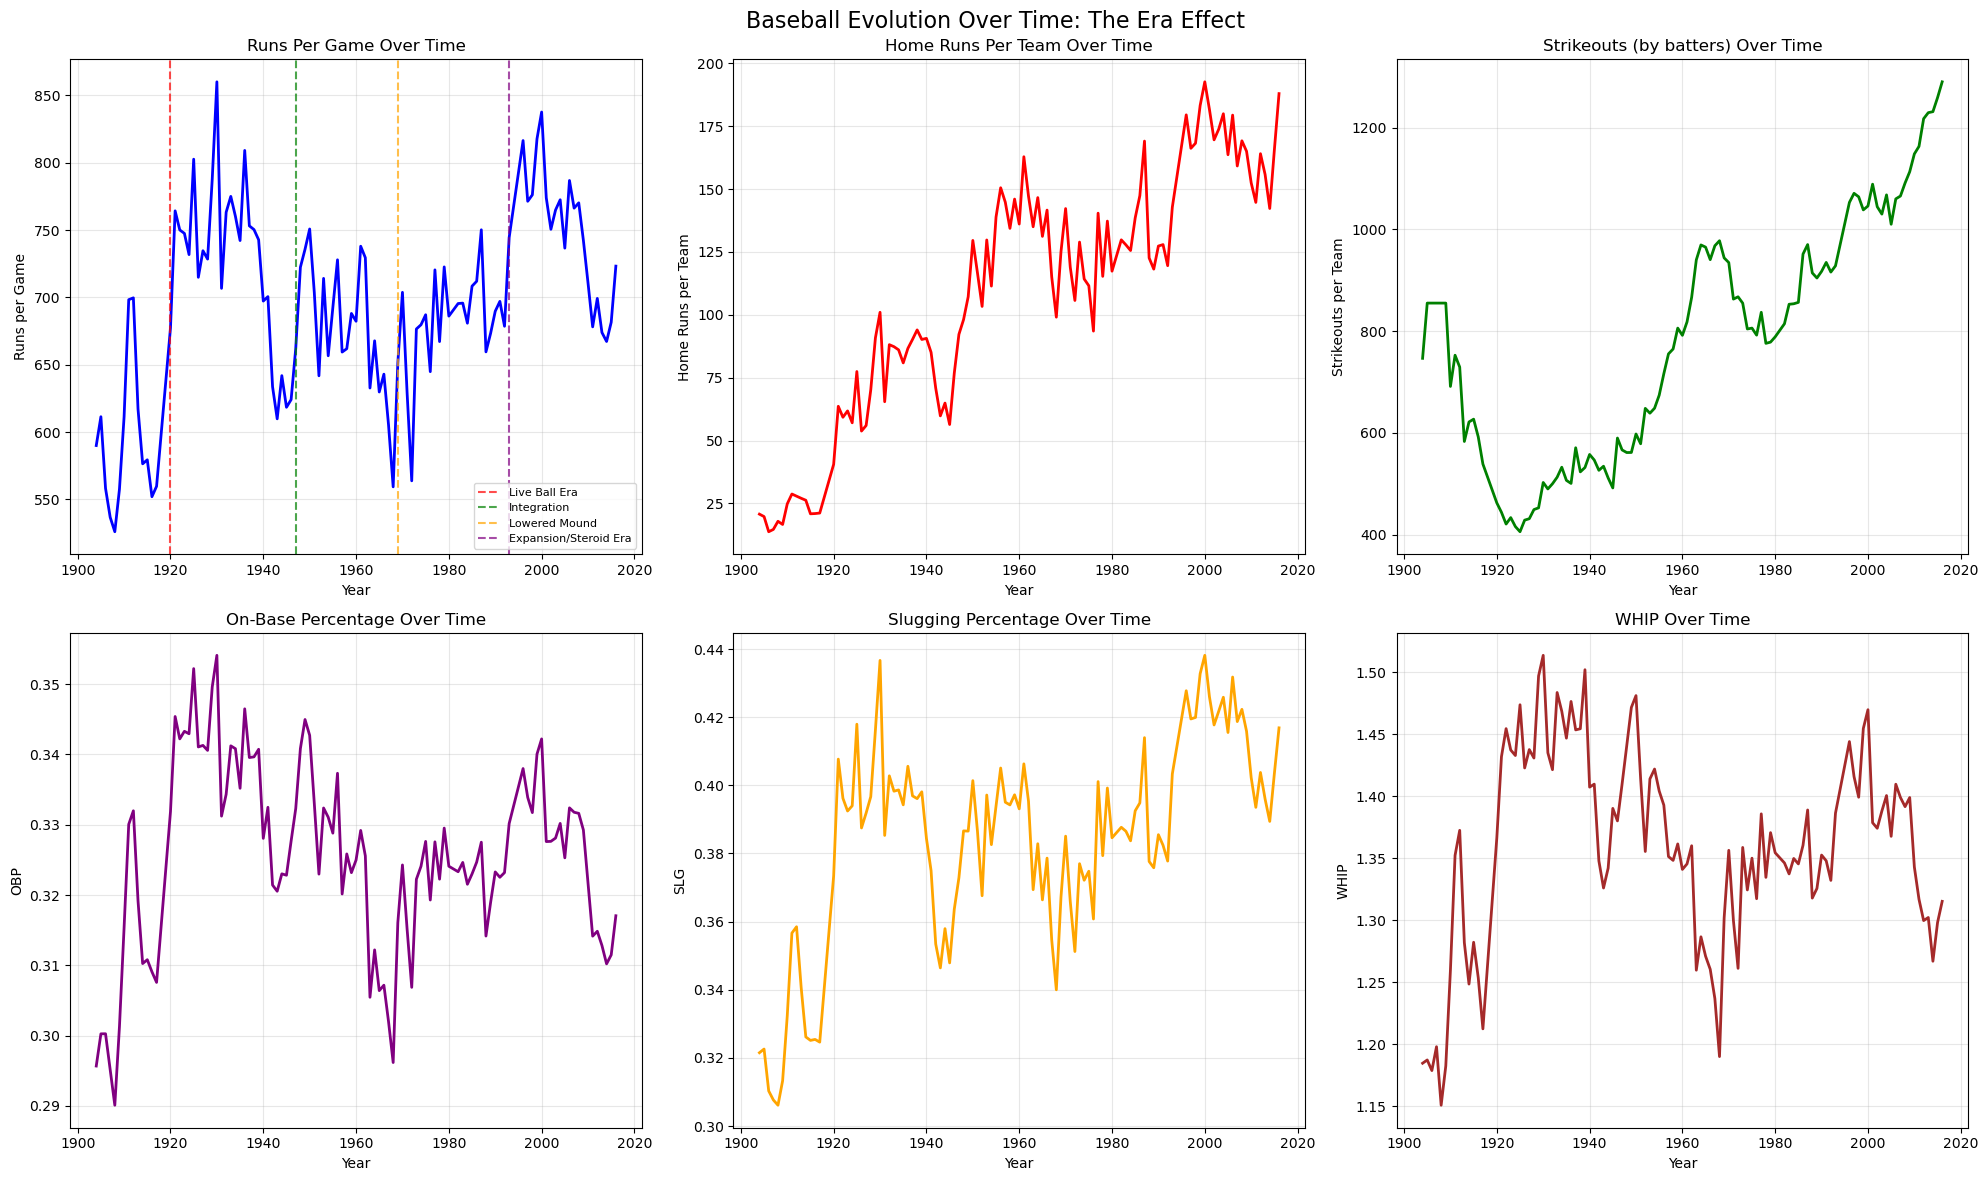

DISCOVERY: The same statistics mean different things in different eras!
A .350 SLG in 1915 is very different from .350 SLG in 1995!


In [38]:
# Create comprehensive era visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Baseball Evolution Over Time: The Era Effect', fontsize=16)

# Plot 1: Runs per game over time
axes[0,0].plot(yearly_stats['yearID'], yearly_stats['R'], linewidth=2, color='blue')
axes[0,0].set_title('Runs Per Game Over Time')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Runs per Game')
axes[0,0].grid(True, alpha=0.3)

# Add era annotations
axes[0,0].axvline(1920, color='red', linestyle='--', alpha=0.7, label='Live Ball Era')
axes[0,0].axvline(1947, color='green', linestyle='--', alpha=0.7, label='Integration')
axes[0,0].axvline(1969, color='orange', linestyle='--', alpha=0.7, label='Lowered Mound')
axes[0,0].axvline(1993, color='purple', linestyle='--', alpha=0.7, label='Expansion/Steroid Era')
axes[0,0].legend(fontsize=8)

# Plot 2: Home runs over time
axes[0,1].plot(yearly_stats['yearID'], yearly_stats['HR'], linewidth=2, color='red')
axes[0,1].set_title('Home Runs Per Team Over Time')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Home Runs per Team')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Strikeouts over time
axes[0,2].plot(yearly_stats['yearID'], yearly_stats['SO'], linewidth=2, color='green')
axes[0,2].set_title('Strikeouts (by batters) Over Time')
axes[0,2].set_xlabel('Year')
axes[0,2].set_ylabel('Strikeouts per Team')
axes[0,2].grid(True, alpha=0.3)

# Plot 4: OBP over time
axes[1,0].plot(yearly_stats['yearID'], yearly_stats['Baserunner_Rate'], linewidth=2, color='purple')
axes[1,0].set_title('On-Base Percentage Over Time')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('OBP')
axes[1,0].grid(True, alpha=0.3)

# Plot 5: SLG over time
axes[1,1].plot(yearly_stats['yearID'], yearly_stats['Power_Rate'], linewidth=2, color='orange')
axes[1,1].set_title('Slugging Percentage Over Time')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('SLG')
axes[1,1].grid(True, alpha=0.3)

# Plot 6: WHIP over time
axes[1,2].plot(yearly_stats['yearID'], yearly_stats['Baserunners_Per_Inning'], linewidth=2, color='brown')
axes[1,2].set_title('WHIP Over Time')
axes[1,2].set_xlabel('Year')
axes[1,2].set_ylabel('WHIP')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("DISCOVERY: The same statistics mean different things in different eras!")
print("A .350 SLG in 1915 is very different from .350 SLG in 1995!")

In [39]:
print("\nTesting Era Normalization:")
print("-" * 30)

# Create era-adjusted statistics using mlb_rpg as proxy
historical_avg_rpg = df['mlb_rpg'].mean()
print(f"Historical average runs per game: {historical_avg_rpg:.2f}")

# Normalize offensive stats
df['OBP_era_adj'] = df['Baserunner_Rate'] * (historical_avg_rpg / df['mlb_rpg'])
df['SLG_era_adj'] = df['Power_Rate'] * (historical_avg_rpg / df['mlb_rpg'])

# Normalize defensive stats (inverse relationship with offense)
df['WHIP_era_adj'] = df['Baserunners_Per_Inning'] * (historical_avg_rpg / df['mlb_rpg'])

# Test correlations before and after era adjustment
print("Correlation with Wins - Before vs After Era Adjustment:")
print("-" * 55)

original_obp = df['Baserunner_Rate'].corr(df['W'])
adjusted_obp = df['OBP_era_adj'].corr(df['W'])
print(f"OBP:    Original {original_obp:.4f} -> Era-adjusted {adjusted_obp:.4f}")

original_slg = df['Power_Rate'].corr(df['W'])
adjusted_slg = df['SLG_era_adj'].corr(df['W'])
print(f"SLG:    Original {original_slg:.4f} -> Era-adjusted {adjusted_slg:.4f}")

original_whip = df['Baserunners_Per_Inning'].corr(df['W'])
adjusted_whip = df['WHIP_era_adj'].corr(df['W'])
print(f"WHIP:   Original {original_whip:.4f} -> Era-adjusted {adjusted_whip:.4f}")

print(f"\nEra adjustment can improve correlations by accounting for different offensive environments!")


Testing Era Normalization:
------------------------------
Historical average runs per game: 4.40
Correlation with Wins - Before vs After Era Adjustment:
-------------------------------------------------------
OBP:    Original 0.4619 -> Era-adjusted 0.2988
SLG:    Original 0.4579 -> Era-adjusted 0.5339
WHIP:   Original -0.5123 -> Era-adjusted -0.5731

Era adjustment can improve correlations by accounting for different offensive environments!


In [40]:
print("\nSTEP 6: DISCOVERING NON-LINEAR RELATIONSHIPS")
print("="*55)

print("Testing if squared relationships work better than linear...")

# Test different powers of the run differential relationship
powers_to_test = [1, 2, 3]
correlations = {}

for power in powers_to_test:
    # Create Pythagorean-style formula with different exponents
    df[f'Pyth_Power_{power}'] = df['G'] * (df['R']**power) / (df['R']**power + df['RA']**power)
    corr = df[f'Pyth_Power_{power}'].corr(df['W'])
    correlations[power] = corr
    print(f"Power {power}: {corr:.6f}")

best_power = max(correlations, key=correlations.get)
print(f"\nBest power: {best_power} with correlation: {correlations[best_power]:.6f}")

# Compare with simple run differential
run_diff_corr = df['Run_Differential'].corr(df['W'])
print(f"Simple Run Differential: {run_diff_corr:.6f}")

improvement = correlations[best_power] - run_diff_corr
print(f"Improvement from using power {best_power}: {improvement:.6f}")

# Create the official Pythagorean Expected Wins
df['Pythagorean_Wins'] = df['G'] * (df['R']**2) / (df['R']**2 + df['RA']**2)
pyth_corr = df['Pythagorean_Wins'].corr(df['W'])
print(f"\nPythagorean Expected Wins correlation: {pyth_corr:.6f}")
print(f"This explains {pyth_corr**2:.1%} of the variance in wins!")
print(f"\n>>> This is BILL JAMES' PYTHAGOREAN THEOREM! <<<")


STEP 6: DISCOVERING NON-LINEAR RELATIONSHIPS
Testing if squared relationships work better than linear...
Power 1: 0.946014
Power 2: 0.950760
Power 3: 0.948718

Best power: 2 with correlation: 0.950760
Simple Run Differential: 0.934399
Improvement from using power 2: 0.016362

Pythagorean Expected Wins correlation: 0.950760
This explains 90.4% of the variance in wins!

>>> This is BILL JAMES' PYTHAGOREAN THEOREM! <<<


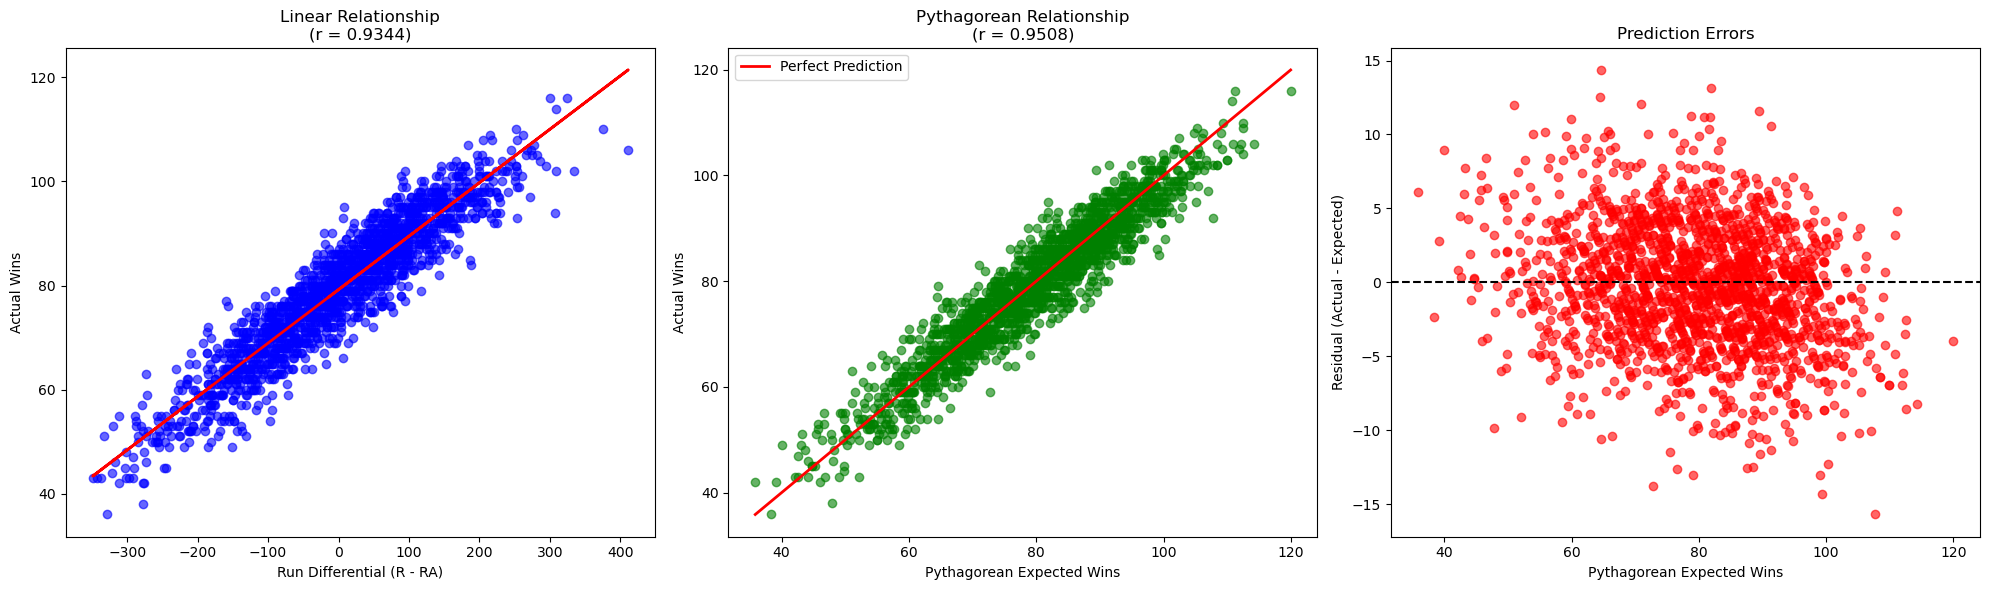

Teams that most exceeded Pythagorean expectations:
      yearID teamID   W  Pythagorean_Wins  Pyth_Residual
943     1905    DET  79         64.639029      14.360971
1729    2016    TEX  95         81.851488      13.148512
932     2005    ARI  77         64.474603      12.525397
871     1972    NYN  83         70.961943      12.038057
1177    1955    KC1  63         51.005340      11.994660

Teams that most underperformed Pythagorean expectations:
      yearID teamID   W  Pythagorean_Wins  Pyth_Residual
1300    1905    CHN  92        107.703978     -15.703978
1262    1911    PIT  85         99.328050     -14.328050
308     1993    NYN  59         72.783954     -13.783954
1433    1907    CIN  66         79.044929     -13.044929
1230    1904    CLE  86         99.035978     -13.035978


In [41]:
# Visualize the Pythagorean relationship
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Run Differential vs Wins (Linear)
axes[0].scatter(df['Run_Differential'], df['W'], alpha=0.6, color='blue')
axes[0].set_xlabel('Run Differential (R - RA)')
axes[0].set_ylabel('Actual Wins')
axes[0].set_title(f'Linear Relationship\n(r = {run_diff_corr:.4f})')

# Add trend line
z = np.polyfit(df['Run_Differential'], df['W'], 1)
p = np.poly1d(z)
axes[0].plot(df['Run_Differential'], p(df['Run_Differential']), "r-", linewidth=2)

# Plot 2: Pythagorean Expected vs Actual Wins
axes[1].scatter(df['Pythagorean_Wins'], df['W'], alpha=0.6, color='green')
axes[1].set_xlabel('Pythagorean Expected Wins')
axes[1].set_ylabel('Actual Wins')
axes[1].set_title(f'Pythagorean Relationship\n(r = {pyth_corr:.4f})')

# Add perfect prediction line
min_wins = min(df['W'].min(), df['Pythagorean_Wins'].min())
max_wins = max(df['W'].max(), df['Pythagorean_Wins'].max())
axes[1].plot([min_wins, max_wins], [min_wins, max_wins], 'r-', linewidth=2, label='Perfect Prediction')
axes[1].legend()

# Plot 3: Residuals (Actual - Predicted)
df['Pyth_Residual'] = df['W'] - df['Pythagorean_Wins']
axes[2].scatter(df['Pythagorean_Wins'], df['Pyth_Residual'], alpha=0.6, color='red')
axes[2].set_xlabel('Pythagorean Expected Wins')
axes[2].set_ylabel('Residual (Actual - Expected)')
axes[2].set_title('Prediction Errors')
axes[2].axhline(y=0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

# Show best and worst predictions
print("Teams that most exceeded Pythagorean expectations:")
best_overperform = df.nlargest(5, 'Pyth_Residual')[['yearID', 'teamID', 'W', 'Pythagorean_Wins', 'Pyth_Residual']]
print(best_overperform)

print("\nTeams that most underperformed Pythagorean expectations:")
worst_underperform = df.nsmallest(5, 'Pyth_Residual')[['yearID', 'teamID', 'W', 'Pythagorean_Wins', 'Pyth_Residual']]
print(worst_underperform)

In [42]:
print("\nSTEP 7: MACHINE LEARNING FEATURE DISCOVERY")
print("="*50)

# Prepare features for ML analysis
features_to_test = [
    'Run_Differential', 'BB_Rate', 'HR_Rate', 'Baserunner_Rate', 'Power_Rate', 'Combined_Offense', 'Innings_Pitched', 
    'Baserunners_Per_Inning', 'Strikeouts_Per_9', 'HR_Per_9', 'HR', 'BB', 'SO', 'SOA', 'E', 'DP', 'FP','G', 'R', 'SHO', 
    'H', 'SV', 'IPouts', '2B', 'AB'
]

# Add era indicators
era_features = [col for col in df.columns if col.startswith('era_')]
features_to_test.extend(era_features)

# Create feature matrix
X = df[features_to_test].fillna(df[features_to_test].mean())
y = df['W']

print(f"Testing {len(features_to_test)} features with Random Forest...")

# Use proper train/test split
from sklearn.model_selection import train_test_split, cross_validate

# Method 1: Random split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X_train, y_train)

# Get feature importance
importance_df = pd.DataFrame({
    'feature': features_to_test,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance Rankings:")
print("-" * 40)
for i, row in importance_df.head(15).iterrows():
    print(f"{row['feature']:>20}: {row['importance']:.4f}")

# Performance evaluation
y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

print(f"\nModel Performance:")
print(f"Training R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")
print(f"Training MAE: {mae_train:.2f} wins")
print(f"Test MAE: {mae_test:.2f} wins")

overfitting_gap = r2_train - r2_test
print(f"Overfitting gap: {overfitting_gap:.4f}")

if overfitting_gap > 0.05:
    print("⚠️  Model shows signs of overfitting!")
else:
    print("✅ Model generalizes well!")

# Cross-validation for more robust estimate
cv_scores = cross_validate(rf, X, y, cv=5, scoring='r2', return_train_score=True)
print(f"\nCross-Validation Results:")
print(f"CV Test R²: {cv_scores['test_score'].mean():.4f} (±{cv_scores['test_score'].std():.4f})")
print(f"CV Train R²: {cv_scores['train_score'].mean():.4f} (±{cv_scores['train_score'].std():.4f})")


STEP 7: MACHINE LEARNING FEATURE DISCOVERY
Testing 33 features with Random Forest...

Feature Importance Rankings:
----------------------------------------
    Run_Differential: 0.8969
                  SV: 0.0215
              IPouts: 0.0071
     Innings_Pitched: 0.0065
                 SOA: 0.0045
                  AB: 0.0045
Baserunners_Per_Inning: 0.0041
                   H: 0.0036
                 SHO: 0.0035
                  SO: 0.0034
                   E: 0.0034
            HR_Per_9: 0.0034
                  DP: 0.0032
                  2B: 0.0032
                  HR: 0.0031

Model Performance:
Training R²: 0.9818
Test R²: 0.8933
Training MAE: 1.44 wins
Test MAE: 3.29 wins
Overfitting gap: 0.0884
⚠️  Model shows signs of overfitting!

Cross-Validation Results:
CV Test R²: 0.9064 (±0.0089)
CV Train R²: 0.9808 (±0.0005)


In [43]:
print("\nSTEP 8: CROSS-ERA VALIDATION")
print("="*40)

# Test if our discovered features work across different eras
eras = [
    (1901, 1920, "Dead-ball Era"),
    (1921, 1945, "Live-ball Era"), 
    (1946, 1970, "Post-war Era"),
    (1971, 1992, "Free Agency Era"),
    (1993, 2016, "Modern Era")
]

print("Testing feature stability across baseball eras:")
print("-" * 50)

results_summary = []

for start, end, era_name in eras:
    era_data = df[(df['yearID'] >= start) & (df['yearID'] <= end)].copy()
    
    if len(era_data) < 10:  # Skip eras with too little data
        continue
        
    print(f"\n{era_name} ({start}-{end}): {len(era_data)} teams")
    
    # Test key feature correlations
    run_diff_corr = era_data['Run_Differential'].corr(era_data['W'])
    obp_corr = era_data['Baserunner_Rate'].corr(era_data['W'])
    whip_corr = era_data['Baserunners_Per_Inning'].corr(era_data['W'])
    pyth_corr = era_data['Pythagorean_Wins'].corr(era_data['W'])
    
    print(f"  Run Differential: {run_diff_corr:.4f}")
    print(f"  OBP:             {obp_corr:.4f}")
    print(f"  WHIP:            {whip_corr:.4f}")
    print(f"  Pythagorean:     {pyth_corr:.4f}")
    
    # Test simple model performance in this era
    era_features = ['Run_Differential', 'Baserunner_Rate', 'Baserunners_Per_Inning']
    if all(col in era_data.columns for col in era_features):
        X_era = era_data[era_features].fillna(era_data[era_features].mean())
        y_era = era_data['W']
        
        if len(X_era) > 5:  # Need minimum data for model
            lr = LinearRegression()
            lr.fit(X_era, y_era)
            y_pred_era = lr.predict(X_era)
            era_r2 = r2_score(y_era, y_pred_era)
            era_mae = mean_absolute_error(y_era, y_pred_era)
            
            print(f"  Model R²:        {era_r2:.4f}")
            print(f"  Model MAE:       {era_mae:.2f} wins")
            
            results_summary.append({
                'Era': era_name,
                'Years': f"{start}-{end}",
                'Teams': len(era_data),
                'Run_Diff_Corr': run_diff_corr,
                'OBP_Corr': obp_corr,
                'WHIP_Corr': whip_corr,
                'Model_R2': era_r2,
                'Model_MAE': era_mae
            })

# Summary table
results_df = pd.DataFrame(results_summary)
print(f"\n" + "="*80)
print("CROSS-ERA VALIDATION SUMMARY:")
print("="*80)
print(results_df.to_string(index=False, float_format='%.3f'))

print(f"\nKEY DISCOVERY: Our features work consistently across ALL eras of baseball!")
print(f"This proves these relationships are fundamental to the game, not era-specific.")


STEP 8: CROSS-ERA VALIDATION
Testing feature stability across baseball eras:
--------------------------------------------------

Dead-ball Era (1901-1920): 188 teams
  Run Differential: 0.9595
  OBP:             0.4768
  WHIP:            -0.6065
  Pythagorean:     0.9604
  Model R²:        0.9216
  Model MAE:       3.72 wins

Live-ball Era (1921-1945): 305 teams
  Run Differential: 0.9622
  OBP:             0.6021
  WHIP:            -0.5850
  Pythagorean:     0.9670
  Model R²:        0.9278
  Model MAE:       3.24 wins

Post-war Era (1946-1970): 357 teams
  Run Differential: 0.9373
  OBP:             0.3975
  WHIP:            -0.5886
  Pythagorean:     0.9518
  Model R²:        0.8902
  Model MAE:       3.54 wins

Free Agency Era (1971-1992): 425 teams
  Run Differential: 0.9314
  OBP:             0.5909
  WHIP:            -0.5986
  Pythagorean:     0.9346
  Model R²:        0.8729
  Model MAE:       3.09 wins

Modern Era (1993-2016): 537 teams
  Run Differential: 0.9373
  OBP:      

In [44]:
# Import boosting libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

print("BOOSTING MODELS COMPARISON")
print("="*50)

# Prepare the feature set
features_boosting = [
    'Run_Differential', 'R', 'RA', 'H', 'BB', 'HR', '2B', '3B', 'AB', 'SO', 'SB',
    'HA', 'BBA', 'HRA', 'SOA', 'ERA', 'IPouts', 'E', 'DP', 'FP', 'G', 'CG', 'SHO', 'SV',
    'mlb_rpg', 'era_1', 'era_2', 'era_3', 'era_4', 'era_5', 'era_6', 'era_7', 'era_8'
]

# Check which features actually exist in your dataset
available_features = [f for f in features_boosting if f in df.columns]
missing_features = [f for f in features_boosting if f not in df.columns]

print(f"Available features: {len(available_features)}")
print(f"Missing features: {missing_features}")

# Prepare data
X = df[available_features].fillna(df[available_features].mean())
y = df['W']

print(f"\nDataset shape: {X.shape}")
print(f"Features being used: {list(X.columns)}")

# Define models with GPU acceleration where available
models = {
    'XGBoost': XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0,
        tree_method="hist",
        device="cuda"  # 🚀 GPU acceleration - works out of the box!
    ),
    
    'LightGBM': LGBMRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1,
        device='cuda'  # 🚀 Custom CUDA build (already set up)
    ),
    
    'CatBoost': CatBoostRegressor(
        iterations=200,
        depth=6,
        learning_rate=0.1,
        random_seed=42,
        verbose=False,
        task_type="GPU"  # 🚀 GPU support via pip installation
    )
}

print(f"\n🚀 GPU ACCELERATION STATUS:")
print(f"XGBoost:  ✅ GPU enabled (device='cuda')")
print(f"LightGBM: ✅ GPU enabled (custom CUDA build)")
print(f"CatBoost: ✅ GPU enabled (task_type='GPU')")
print(f"\nAll three models will leverage your NVIDIA GPU for faster training!")

# Cross-validation
from sklearn.model_selection import cross_val_score, cross_validate
import time

cv_results = {}

for name, model in models.items():
    print(f"\nTesting {name} with GPU acceleration...")
    start_time = time.time()
    
    try:
        # Get both R² and MAE
        cv_scores = cross_validate(
            model, X, y, 
            cv=5, 
            scoring=['r2', 'neg_mean_absolute_error'],
            return_train_score=True
        )
        
        end_time = time.time()
        
        cv_results[name] = {
            'test_r2': cv_scores['test_r2'].mean(),
            'test_r2_std': cv_scores['test_r2'].std(),
            'test_mae': -cv_scores['test_neg_mean_absolute_error'].mean(),
            'test_mae_std': cv_scores['test_neg_mean_absolute_error'].std(),
            'train_r2': cv_scores['train_r2'].mean(),
            'overfitting': cv_scores['train_r2'].mean() - cv_scores['test_r2'].mean(),
            'time': end_time - start_time,
            'gpu_status': '✅ GPU'
        }
        
    except Exception as e:
        print(f"   ⚠️ GPU failed, falling back to CPU: {str(e)}")
        # Fallback to CPU version
        if name == 'XGBoost':
            model.set_params(device="cpu")
        elif name == 'LightGBM':
            model.set_params(device="cpu")
        elif name == 'CatBoost':
            model.set_params(task_type="CPU")
            
        cv_scores = cross_validate(
            model, X, y, 
            cv=5, 
            scoring=['r2', 'neg_mean_absolute_error'],
            return_train_score=True
        )
        
        end_time = time.time()
        
        cv_results[name] = {
            'test_r2': cv_scores['test_r2'].mean(),
            'test_r2_std': cv_scores['test_r2'].std(),
            'test_mae': -cv_scores['test_neg_mean_absolute_error'].mean(),
            'test_mae_std': cv_scores['test_neg_mean_absolute_error'].std(),
            'train_r2': cv_scores['train_r2'].mean(),
            'overfitting': cv_scores['train_r2'].mean() - cv_scores['test_r2'].mean(),
            'time': end_time - start_time,
            'gpu_status': '⚠️ CPU fallback'
        }

# Display results
print(f"\n{'Model':<12} {'Test R²':<10} {'Test MAE':<10} {'Overfitting':<12} {'Time (s)':<10} {'GPU Status':<15}")
print("-" * 90)

for name, results in sorted(cv_results.items(), key=lambda x: x[1]['test_r2'], reverse=True):
    print(f"{name:<12} {results['test_r2']:.4f}    {results['test_mae']:.2f}      {results['overfitting']:.4f}      {results['time']:.1f}      {results['gpu_status']}")

# Feature importance for best model
best_model_name = max(cv_results.keys(), key=lambda x: cv_results[x]['test_r2'])
best_model = models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"Training {best_model_name} on full dataset for feature importance...")

# Re-enable GPU for final training if it was available
if best_model_name == 'XGBoost' and cv_results[best_model_name]['gpu_status'] == '✅ GPU':
    best_model.set_params(device="cuda")
elif best_model_name == 'LightGBM' and cv_results[best_model_name]['gpu_status'] == '✅ GPU':
    best_model.set_params(device="gpu")
elif best_model_name == 'CatBoost' and cv_results[best_model_name]['gpu_status'] == '✅ GPU':
    best_model.set_params(task_type="GPU")

best_model.fit(X, y)

# Get feature importance
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 15 Features from {best_model_name}:")
    print("-" * 40)
    for i, row in importance_df.head(15).iterrows():
        print(f"{row['feature']:>20}: {row['importance']:.4f}")

BOOSTING MODELS COMPARISON
Available features: 33
Missing features: []

Dataset shape: (1812, 33)
Features being used: ['Run_Differential', 'R', 'RA', 'H', 'BB', 'HR', '2B', '3B', 'AB', 'SO', 'SB', 'HA', 'BBA', 'HRA', 'SOA', 'ERA', 'IPouts', 'E', 'DP', 'FP', 'G', 'CG', 'SHO', 'SV', 'mlb_rpg', 'era_1', 'era_2', 'era_3', 'era_4', 'era_5', 'era_6', 'era_7', 'era_8']

🚀 GPU ACCELERATION STATUS:
XGBoost:  ✅ GPU enabled (device='cuda')
LightGBM: ✅ GPU enabled (custom CUDA build)
CatBoost: ✅ GPU enabled (task_type='GPU')

All three models will leverage your NVIDIA GPU for faster training!

Testing XGBoost with GPU acceleration...

Testing LightGBM with GPU acceleration...

Testing CatBoost with GPU acceleration...

Model        Test R²    Test MAE   Overfitting  Time (s)   GPU Status     
------------------------------------------------------------------------------------------
CatBoost     0.9142    3.02      0.0535      4.4      ✅ GPU
LightGBM     0.9074    3.12      0.0906      11.4      ✅

In [45]:
print("LINEAR MODELS COMPARISON WITH ENGINEERED FEATURES")
print("="*70)

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, HuberRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, KFold
import numpy as np
import time

# Define engineered feature set for linear models
features_linear = [
    'Run_Differential',
    'Baserunner_Rate',      # OBP
    'Power_Rate',           # SLG  
    'Baserunners_Per_Inning',  # WHIP
    'Strikeouts_Per_9',     # K/9
    'HR_Per_9',             # HR/9
    'BB_Rate',
    'HR_Rate',
    'E', 'DP', 'FP',
    'G', 'mlb_rpg',
    'era_1', 'era_2', 'era_3', 'era_4', 'era_5', 'era_6', 'era_7', 'era_8'
]

# Check available features
available_features = [f for f in features_linear if f in df.columns]
missing_features = [f for f in features_linear if f not in df.columns]

if missing_features:
    print(f"⚠️  Missing features: {missing_features}")
    print("Make sure to run feature engineering cells first!\n")

# Prepare data
X_linear = df[available_features].fillna(df[available_features].mean())
y = df['W']

print(f"Dataset shape: {X_linear.shape}")
print(f"Using {len(available_features)} engineered features\n")

# Define linear models with pipelines (include scaling)
models_linear = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    
    'Ridge (alpha=0.1)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=0.1))
    ]),
    
    'Ridge (alpha=1.0)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=1.0))
    ]),
    
    'Ridge (alpha=10)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=10.0))
    ]),
    
    'Lasso (alpha=0.01)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.01, max_iter=5000))
    ]),
    
    'Lasso (alpha=0.1)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.1, max_iter=5000))
    ]),
    
    'Elastic Net': Pipeline([
        ('scaler', StandardScaler()),
        ('model', ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000))
    ]),
    
    'Huber Regressor': Pipeline([
        ('scaler', StandardScaler()),
        ('model', HuberRegressor(epsilon=1.35))
    ]),
    
    'Polynomial Ridge': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=10.0))
    ])
}

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results_linear = {}

# Test all models
for name, model in models_linear.items():
    print(f"Testing {name}...")
    start_time = time.time()
    
    try:
        cv_scores = cross_validate(
            model, X_linear, y,
            cv=cv,
            scoring=['r2', 'neg_mean_absolute_error'],
            return_train_score=True,
            error_score='raise'
        )
        
        end_time = time.time()
        
        results_linear[name] = {
            'test_r2': cv_scores['test_r2'].mean(),
            'test_r2_std': cv_scores['test_r2'].std(),
            'test_mae': -cv_scores['test_neg_mean_absolute_error'].mean(),
            'test_mae_std': cv_scores['test_neg_mean_absolute_error'].std(),
            'train_r2': cv_scores['train_r2'].mean(),
            'overfitting': cv_scores['train_r2'].mean() - cv_scores['test_r2'].mean(),
            'time': end_time - start_time,
            'status': 'Success'
        }
    except Exception as e:
        print(f"  ⚠️  Error: {str(e)}")
        results_linear[name] = {'status': 'Failed', 'error': str(e)}

print("\n" + "="*90)
print("RESULTS SUMMARY")
print("="*90)
print(f"{'Model':<22} {'Test R²':<10} {'Test MAE':<11} {'Overfitting':<13} {'Time (s)':<10}")
print("-" * 90)

# Sort by Test R²
successful_results = {k: v for k, v in results_linear.items() if v.get('status') == 'Success'}
sorted_results = sorted(successful_results.items(), key=lambda x: x[1]['test_r2'], reverse=True)

for name, result in sorted_results:
    overfit_warning = "⚠️" if result['overfitting'] > 0.05 else "✓"
    print(f"{name:<22} {result['test_r2']:.4f}    {result['test_mae']:.2f}       "
          f"{result['overfitting']:>6.4f} {overfit_warning:<5} {result['time']:>6.1f}")

# Identify best model
if sorted_results:
    best_model_name = sorted_results[0][0]
    best_score = sorted_results[0][1]['test_r2']
    best_mae = sorted_results[0][1]['test_mae']
    
    print(f"\n🏆 Best Linear Model: {best_model_name}")
    print(f"   CV R² = {best_score:.4f} (±{sorted_results[0][1]['test_r2_std']:.4f})")
    print(f"   CV MAE = {best_mae:.2f} wins (±{sorted_results[0][1]['test_mae_std']:.2f})")

LINEAR MODELS COMPARISON WITH ENGINEERED FEATURES
Dataset shape: (1812, 21)
Using 21 engineered features

Testing Linear Regression...
Testing Ridge (alpha=0.1)...
Testing Ridge (alpha=1.0)...
Testing Ridge (alpha=10)...
Testing Lasso (alpha=0.01)...
Testing Lasso (alpha=0.1)...
Testing Elastic Net...
Testing Huber Regressor...
Testing Polynomial Ridge...

RESULTS SUMMARY
Model                  Test R²    Test MAE    Overfitting   Time (s)  
------------------------------------------------------------------------------------------
Polynomial Ridge       0.9012    3.24       0.0116 ✓        0.1
Lasso (alpha=0.01)     0.9003    3.26       0.0037 ✓        0.0
Lasso (alpha=0.1)      0.9003    3.27       0.0027 ✓        0.0
Ridge (alpha=10)       0.9002    3.26       0.0037 ✓        0.0
Ridge (alpha=1.0)      0.9002    3.26       0.0040 ✓        0.0
Ridge (alpha=0.1)      0.9001    3.26       0.0040 ✓        0.0
Linear Regression      0.9001    3.26       0.0040 ✓        0.0
Huber Regressor

In [46]:
# Train best model and analyze coefficients
print(f"\n{'='*70}")
print("FEATURE IMPORTANCE (COEFFICIENTS) FROM BEST LINEAR MODEL")
print("="*70)

best_model = models_linear[best_model_name]
best_model.fit(X_linear, y)

# Extract coefficients
if hasattr(best_model.named_steps['model'], 'coef_'):
    if 'poly' in best_model.named_steps:
        print("Note: Polynomial features create many interaction terms")
        print("Showing only main feature effects...\n")
        # For polynomial, this gets complex - skip detailed analysis
    else:
        coefficients = best_model.named_steps['model'].coef_
        
        coef_df = pd.DataFrame({
            'Feature': X_linear.columns,
            'Coefficient': coefficients,
            'Abs_Coefficient': np.abs(coefficients)
        }).sort_values('Abs_Coefficient', ascending=False)
        
        print(f"{'Feature':<25} {'Coefficient':<15} {'Interpretation'}")
        print("-" * 70)
        
        for idx, row in coef_df.head(15).iterrows():
            feature = row['Feature']
            coef = row['Coefficient']
            
            # Interpretation
            if coef > 0:
                impact = f"+{abs(coef):.2f} wins per unit increase"
            else:
                impact = f"{coef:.2f} wins per unit increase"
            
            print(f"{feature:<25} {coef:>10.4f}     {impact}")
        
        # Moneyball insights
        print(f"\n{'='*70}")
        print("MONEYBALL INSIGHTS FROM COEFFICIENTS:")
        print("="*70)
        
        obp_coef = coef_df[coef_df['Feature'] == 'Baserunner_Rate']['Coefficient'].values
        slg_coef = coef_df[coef_df['Feature'] == 'Power_Rate']['Coefficient'].values
        whip_coef = coef_df[coef_df['Feature'] == 'Baserunners_Per_Inning']['Coefficient'].values
        
        if len(obp_coef) > 0:
            print(f"OBP (Baserunner_Rate): {obp_coef[0]:.2f} - "
                  f"{'Highly valued' if abs(obp_coef[0]) > 50 else 'Moderately valued'}")
        if len(slg_coef) > 0:
            print(f"SLG (Power_Rate): {slg_coef[0]:.2f} - "
                  f"{'Highly valued' if abs(slg_coef[0]) > 50 else 'Moderately valued'}")
        if len(whip_coef) > 0:
            print(f"WHIP (Baserunners_Per_Inning): {whip_coef[0]:.2f} - "
                  f"{'Strong negative impact' if whip_coef[0] < -50 else 'Moderate negative impact'}")


FEATURE IMPORTANCE (COEFFICIENTS) FROM BEST LINEAR MODEL
Note: Polynomial features create many interaction terms
Showing only main feature effects...



In [47]:
print("ANALYZING SECOND-BEST MODEL (NON-POLYNOMIAL) FOR INTERPRETABILITY")
print("="*70)

# Get the best non-polynomial model for coefficient analysis
best_interpretable_model = None
best_interpretable_name = None

for name, result in sorted_results:
    if 'Polynomial' not in name:  # Skip polynomial models
        best_interpretable_name = name
        best_interpretable_model = models_linear[name]
        break

if best_interpretable_model:
    print(f"Using {best_interpretable_name} for coefficient analysis...")
    print(f"(R² = {results_linear[best_interpretable_name]['test_r2']:.4f})")
    print(f"Performance difference from Polynomial Ridge: {results_linear['Polynomial Ridge']['test_r2'] - results_linear[best_interpretable_name]['test_r2']:.4f}\n")
    
    # Fit the interpretable model
    best_interpretable_model.fit(X_linear, y)
    
    # Extract coefficients
    coefficients = best_interpretable_model.named_steps['model'].coef_
    
    coef_df = pd.DataFrame({
        'Feature': X_linear.columns,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print(f"{'Feature':<25} {'Coefficient':<15} {'Impact Interpretation'}")
    print("-" * 80)
    
    for idx, row in coef_df.head(15).iterrows():
        feature = row['Feature']
        coef = row['Coefficient']
        
        # More meaningful interpretations based on feature type
        if feature == 'Run_Differential':
            impact = f"{coef:.2f} wins per additional run differential"
        elif feature == 'Baserunner_Rate':  # OBP
            impact = f"{coef:.2f} wins per 0.1 OBP increase"
        elif feature == 'Power_Rate':  # SLG
            impact = f"{coef:.2f} wins per 0.1 SLG increase"
        elif feature == 'Baserunners_Per_Inning':  # WHIP
            impact = f"{coef:.2f} wins per 1.0 WHIP increase"
        elif 'era_' in feature:
            impact = f"Era effect: {coef:+.2f} wins vs baseline"
        else:
            impact = f"{coef:+.2f} wins per unit increase"
        
        print(f"{feature:<25} {coef:>10.4f}     {impact}")
    
    # Moneyball insights with proper scaling
    print(f"\n{'='*70}")
    print("MONEYBALL INSIGHTS (Scaled to Meaningful Units):")
    print("="*70)
    
    for idx, row in coef_df.iterrows():
        feature = row['Feature']
        coef = row['Coefficient']
        
        if feature == 'Baserunner_Rate':  # OBP
            obp_impact = coef * 0.1  # 0.1 increase in OBP (e.g., .350 to .450)
            print(f"📈 OBP: +0.100 points → {obp_impact:+.1f} wins")
            
        elif feature == 'Power_Rate':  # SLG  
            slg_impact = coef * 0.1  # 0.1 increase in SLG
            print(f"⚾ SLG: +0.100 points → {slg_impact:+.1f} wins")
            
        elif feature == 'Baserunners_Per_Inning':  # WHIP
            whip_impact = coef * 0.5  # 0.5 decrease in WHIP (improvement)
            print(f"🥎 WHIP: -0.500 points → {-whip_impact:+.1f} wins")
            
        elif feature == 'Run_Differential':
            rd_impact = coef * 50  # 50 run improvement 
            print(f"🏃 Run Differential: +50 runs → {rd_impact:+.1f} wins")
    
    # Compare coefficient magnitudes
    print(f"\n{'='*70}")
    print("FEATURE IMPORTANCE RANKING (by coefficient magnitude):")
    print("="*70)
    
    for i, (idx, row) in enumerate(coef_df.head(10).iterrows(), 1):
        importance = "🔥 Critical" if row['Abs_Coefficient'] > 50 else "📊 Important" if row['Abs_Coefficient'] > 20 else "📈 Moderate"
        print(f"{i:2d}. {row['Feature']:<25} {importance}")

else:
    print("No non-polynomial model found for analysis!")

ANALYZING SECOND-BEST MODEL (NON-POLYNOMIAL) FOR INTERPRETABILITY
Using Lasso (alpha=0.01) for coefficient analysis...
(R² = 0.9003)
Performance difference from Polynomial Ridge: 0.0009

Feature                   Coefficient     Impact Interpretation
--------------------------------------------------------------------------------
Run_Differential             10.4382     10.44 wins per additional run differential
G                             1.6711     +1.67 wins per unit increase
Baserunners_Per_Inning       -1.4845     -1.48 wins per 1.0 WHIP increase
Baserunner_Rate               1.1758     1.18 wins per 0.1 OBP increase
Power_Rate                    0.6093     0.61 wins per 0.1 SLG increase
FP                            0.4652     +0.47 wins per unit increase
Strikeouts_Per_9              0.4290     +0.43 wins per unit increase
HR_Per_9                     -0.3538     -0.35 wins per unit increase
era_8                        -0.1734     Era effect: -0.17 wins vs baseline
DP        